In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity, cosine_distances
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from time import clock
import json
import torch
import torch.nn as nn

# Loading Data

Load the recipe data from a file and get rid of all non-ingredient columns.

In [2]:
df = pd.read_csv("epi_r.csv")

with open("./full_format_recipes.json") as f:
    full_format = json.loads(f.read())

titles = df.title
with open("ingredient_columns.txt", encoding="utf8") as f:
    ingredient_names = sorted([line.strip() for line in f.readlines() if line.strip() in df.columns.values])

df = df[ingredient_names]

Get rid of ingredients that aren't used often enough

In [3]:
min_recipes = 10

ingredient_names = df.columns[np.sum(df.values, axis=0) > min_recipes].values
num_ing = len(ingredient_names)

df = df[ingredient_names]

Remove recipes with less than two ingredients

In [4]:
df = df[np.count_nonzero(df.values, axis=1) >= 2]

ingredient_names = df.columns[np.sum(df.values, axis=0) > min_recipes].values
num_ing = len(ingredient_names)

df = df[ingredient_names]

ingredient_indices = {name:i for i, name in enumerate(ingredient_names)}

def get_ingredients(recipe):
    return [ingredient_names[x] for x in np.nonzero(recipe)[0]]



Split the data into train, dev, and test sets

In [5]:
def train_dev_test(df, dev_size, test_size):
    dev_test_size = dev_size + test_size
    train, dev_test = train_test_split(df, test_size = dev_test_size)
    dev, test = train_test_split(dev_test, test_size = test_size / dev_test_size)
    return train, dev, test

train, dev, test = train_dev_test(df, 0.1, 0.1)
len(train), len(dev), len(test)

(14936, 1867, 1868)

# Generating Embeddings

## PCA
Calculate the co-occurrence matrix and use PCA to convert it into word embeddings.

In [6]:
def co_occurrence(df, reduced_size):
    co_occurrence = df.T.dot(df)
    np.fill_diagonal(co_occurrence.values, 0)
    pca = PCA(reduced_size)
    reduced = pca.fit_transform(co_occurrence)
    return pd.DataFrame(co_occurrence, columns=ingredient_names), pd.DataFrame(reduced.T, columns = ingredient_names)

co_occur, embed_pca = co_occurrence(train, 100)
embed_pca

,alcoholic,almond,amaretto,anchovy,anise,apple,apricot,artichoke,arugula,asian pear,...,watercress,watermelon,whiskey,white wine,whole wheat,wild rice,wine,yellow squash,yogurt,zucchini
0,3.915029,44.051744,-74.705923,-71.431857,-55.047199,81.317290,-22.501768,-29.437360,18.581279,-77.855412,...,-42.926089,-65.098590,-73.533114,106.191745,-76.022480,-75.538007,-26.808779,-71.872801,67.124492,52.931465
1,189.374690,146.169361,1.925033,-18.504836,4.675983,145.736665,70.546142,-30.306039,-38.728937,-13.925545,...,-15.074499,0.808181,-0.393910,-25.292542,-9.450477,-13.637940,2.095118,-18.848093,38.244894,-53.555814
2,292.058150,-36.430270,-8.508246,-9.849295,5.121559,12.099098,-3.841218,-6.045254,-11.451009,-7.414793,...,-7.306468,2.909545,7.660349,22.907843,-11.402979,-8.437026,26.424709,-8.734636,-2.076618,-15.934696
3,-22.081634,-0.291073,-0.499711,0.172131,-1.351560,24.082628,3.941900,5.304312,-11.976615,-0.581802,...,-5.171491,0.319060,2.014992,-8.986510,-0.833306,1.144520,0.095169,2.354546,-2.303515,-3.760971
4,143.213277,-54.699762,4.925933,4.328728,-10.843220,-93.508832,-41.932217,6.306685,11.958107,-3.654704,...,-3.201983,-6.681202,9.055044,15.668247,-0.372600,-2.519574,-1.737099,1.974928,-33.901844,20.493434
5,14.238936,-2.798665,4.204505,2.487022,6.937905,-151.690495,-49.078455,6.271179,1.397428,2.193776,...,5.747870,-15.726918,2.629506,-6.805579,5.335064,2.958078,-2.832389,5.083950,4.714942,6.742880
6,7.825687,7.801903,0.767812,2.913250,-1.067768,-56.683662,-10.508559,1.874226,7.760121,2.155380,...,4.124495,-4.097698,1.783523,-28.270259,5.351322,3.583052,1.920104,2.697760,18.437587,13.002593
7,-42.475262,6.298670,-1.770959,-1.327256,-1.573083,-24.501655,-3.534782,-3.604502,-4.532059,-0.566327,...,1.432143,4.515944,-5.538554,11.317923,-0.991384,-1.732848,-6.713930,-1.138363,20.657279,-10.293405
8,-19.046540,-13.246291,1.703846,2.772608,2.658854,9.818243,5.240331,-8.958353,0.930078,2.451694,...,1.401111,4.237547,1.521294,-1.756927,0.856965,1.360968,3.212550,1.236766,10.937665,-27.752100
9,3.108430,19.707067,2.014649,5.447946,6.026379,-33.764037,-3.900603,-5.733168,-0.706352,2.518804,...,2.577758,2.188240,3.033210,-14.542786,2.297361,2.674376,3.206668,2.092284,-8.217230,-18.041320


## CBOW

Convert the train, dev, and test data into appropriate forms for the CBOW model

In [7]:
def build_context(df):
    recipe_lens = np.count_nonzero(df.values, axis=1)
    recipe_len_uniques, recipe_len_counts = np.unique(recipe_lens, return_counts=True)

    context_batches = []
    target_batches = []

    for recipe_len, count in zip(recipe_len_uniques, recipe_len_counts):
        recipes = df[recipe_lens == recipe_len].values


        context_batch = []
        target_batch = []


        for recipe in recipes:
            ings = recipe.nonzero()[0]
            for target in ings:
                nontarget = ings[ings != target]
                target_batch.append(target)
                context = np.zeros((recipe_len - 1, num_ing))
                context[np.arange(recipe_len - 1), nontarget] = 1
                context_batch.append(context)

        context_batch = torch.FloatTensor(context_batch)
        target_batch = torch.LongTensor(target_batch)

        context_batches.append(context_batch)
        target_batches.append(target_batch)
    return context_batches, target_batches
        
train_context, train_target = build_context(train)
dev_context, dev_target = build_context(dev)
test_context, test_target = build_context(test)

[(x.shape, y.shape) for x, y in zip(train_context, train_target)]

[(torch.Size([3754, 1, 312]), torch.Size([3754])),
 (torch.Size([9849, 2, 312]), torch.Size([9849])),
 (torch.Size([13484, 3, 312]), torch.Size([13484])),
 (torch.Size([14095, 4, 312]), torch.Size([14095])),
 (torch.Size([10908, 5, 312]), torch.Size([10908])),
 (torch.Size([6769, 6, 312]), torch.Size([6769])),
 (torch.Size([3704, 7, 312]), torch.Size([3704])),
 (torch.Size([1890, 8, 312]), torch.Size([1890])),
 (torch.Size([810, 9, 312]), torch.Size([810])),
 (torch.Size([264, 10, 312]), torch.Size([264])),
 (torch.Size([168, 11, 312]), torch.Size([168])),
 (torch.Size([52, 12, 312]), torch.Size([52])),
 (torch.Size([42, 13, 312]), torch.Size([42])),
 (torch.Size([15, 14, 312]), torch.Size([15])),
 (torch.Size([21, 20, 312]), torch.Size([21]))]

Train the CBOW model to get the CBOW embeddings and what I am calling the encodings. The embeddings are the trained weights between the hidden and output layers and the encodings are the trained weights between the input and hidden layers.

Epoch 100: 0.077506 seconds / epoch
Epoch 200: 0.076222 seconds / epoch
Epoch 300: 0.075526 seconds / epoch
Epoch 400: 0.075342 seconds / epoch
Epoch 500: 0.075287 seconds / epoch
Epoch 600: 0.075200 seconds / epoch
Epoch 700: 0.075260 seconds / epoch
Epoch 800: 0.075161 seconds / epoch
Epoch 900: 0.075087 seconds / epoch
Epoch 1000: 0.074997 seconds / epoch
Epoch 1100: 0.074936 seconds / epoch
Epoch 1200: 0.074896 seconds / epoch
Epoch 1300: 0.074870 seconds / epoch
Epoch 1400: 0.074863 seconds / epoch
Epoch 1500: 0.074822 seconds / epoch
Epoch 1600: 0.074801 seconds / epoch
Epoch 1700: 0.074791 seconds / epoch
Epoch 1800: 0.074768 seconds / epoch
Epoch 1900: 0.074750 seconds / epoch
Epoch 2000: 0.074750 seconds / epoch
Epoch 2100: 0.074755 seconds / epoch
Epoch 2200: 0.074754 seconds / epoch
Epoch 2300: 0.074755 seconds / epoch
Epoch 2400: 0.074747 seconds / epoch
Epoch 2500: 0.074724 seconds / epoch
Epoch 2600: 0.074714 seconds / epoch
Epoch 2700: 0.074705 seconds / epoch
Epoch 2800

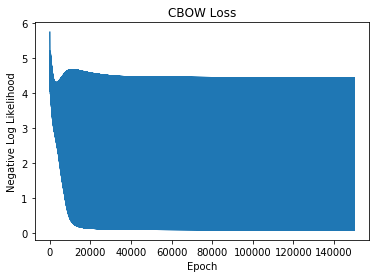

In [8]:
class CBOW(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(CBOW, self).__init__()

        self.linear1 = nn.Linear(vocab_size, embedding_dim)
        
        self.linear2 = nn.Linear(embedding_dim, vocab_size)
        
        self.activation = nn.LogSoftmax(dim=1)
    
    def forward(self, inputs):
        out = self.linear1(inputs)
        out = out.mean(dim=1)
        out = self.linear2(out)
        out = self.activation(out)
        return out
    
    def get_embeddings(self):
        params = list(self.linear2.parameters())
        w = params[0]
        h = params[1]
        if w.is_cuda:
            w = w.cpu()
        if h.is_cuda:
            h = h.cpu()
        w = w.detach().numpy()
        h = h.detach().numpy()
        return pd.DataFrame(np.hstack([w, np.expand_dims(h, 1)]).T, columns = ingredient_names)
    
    def get_encodings(self):
        params = list(self.linear1.parameters())
        w = params[0]
        h = params[1]
        if w.is_cuda:
            w = w.cpu()
        if h.is_cuda:
            h = h.cpu()
        w = w.detach().numpy()
        h = h.detach().numpy()
        return pd.DataFrame(w, columns = ingredient_names)


model = CBOW(num_ing, 50)
if torch.cuda.is_available():
    device = torch.device("cuda:1")
    train_context = [x.to(device=device) for x in train_context]
    train_target = [x.to(device=device) for x in train_target]
    model = model.to(device)



loss_function = nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters())

n_epochs = 10000
start = clock()
epoch_time = []
losses = []
for epoch in range(n_epochs):
    if 100 * epoch  // n_epochs != 100 * (epoch - 1)  // n_epochs and epoch != 0:
        print("Epoch %d: %f seconds / epoch"%(epoch, np.mean(epoch_time)))
    total_loss = 0
    for in_tensor, out_tensor in zip(train_context, train_target):
        model.zero_grad()
        log_probs = model(in_tensor)
        loss = loss_function(log_probs, out_tensor)
        loss.backward()
        optimizer.step()

        losses.append(loss.data.cpu().detach().numpy())
    epoch_time.append(clock() - start)
    start = clock()
    
train_context = [x.to(device="cpu") for x in train_context]
train_target = [x.to(device="cpu") for x in train_target]
model = model.to("cpu")

correct = 0
total = 0
for in_tensor, out_tensor in zip(test_context, test_target):
    log_probs = model(in_tensor).data.detach().numpy()
    out_tensor = out_tensor.data.numpy()
    predictions = np.max(log_probs, axis=1)
    correct += np.sum(predictions == out_tensor.data)
    total += len(predictions)

embed_cbow = model.get_embeddings()
encode_cbow = model.get_encodings()

print("Accuracy: %f%%"%(100 * correct / total))

plt.title("CBOW Loss")
plt.xlabel("Epoch")
plt.ylabel("Negative Log Likelihood")
plt.plot(range(len(losses)), losses)

Save the embeddings to files

In [9]:
def save_embed(fname, embed):
    np.savetxt(fname, embed.values.T, delimiter="\t")
save_embed("cbow.txt", embed_cbow)
save_embed("count.txt", df)
save_embed("pca.txt", embed_pca)
with open("ing.txt", "w", encoding="utf8") as f:
    f.write("\n".join(ingredient_names))

# Embedding Evaluation

Functions to translate between one-hot vectors and embeddings as well as finding the closest ingredients to a given ingredient in the embedding space.

In [10]:
def to_embeddings(mat, embedding):
    return mat.dot(embedding.values.T)

def n_closest(n, vec, embeddings):
    if len(vec.shape) == 1:
        vec = vec[None, :]
    distances = zip(embeddings.columns, cosine_similarity(vec, embeddings.T)[0])
    return sorted(distances, key=lambda x: x[1], reverse=True)[:n]

def most_similar_co_occur(ing, n=10):
    if ing not in ingredient_names:
        return []
    
    vec = co_occur[ing].values
    return n_closest(n+1, vec, co_occur)[1:]

def most_similar_embed_pca(ing, n=10):
    if ing not in ingredient_names:
        return []
    
    vec = embed_pca[ing].values
    return n_closest(n+1, vec, embed_pca)[1:]

def most_similar_cbow(ing, n=10):
    if ing not in ingredient_names:
        return []
    
    vec = embed_cbow[ing].values
    return n_closest(n+1, vec, embed_cbow)[1:]

def most_similar_encode_cbow(ing, n=10):
    if ing not in ingredient_names:
        return []
    
    vec = encode_cbow[ing].values
    return n_closest(n+1, vec, encode_cbow)[1:]

Compare the most similar ingredients to an avocado between the four embedding schemes

In [11]:
n = 5
print("Co-Occurrence:", most_similar_co_occur("avocado", n))
print()
print("PCA:", most_similar_embed_pca("avocado", n))
print()
print("CBOW:", most_similar_cbow("avocado", n))
print()
print("Encode:", most_similar_encode_cbow("avocado", n))

Co-Occurrence: [('jalapeño', 0.8102710228188078), ('bell pepper', 0.7915948732277475), ('hot pepper', 0.7759581754408029), ('pepper', 0.770926401070099), ('corn', 0.7579576183196391)]

PCA: [('jalapeño', 0.5875430423211574), ('hot pepper', 0.4688444219405), ('corn', 0.45937809598616364), ('cilantro', 0.42221428925612714), ('cucumber', 0.4212753735125239)]

CBOW: [('sour cream', 0.56993645), ('mayonnaise', 0.47623724), ('jícama', 0.46838218), ('coriander', 0.38844696), ('tortillas', 0.35379344)]

Encode: [('jícama', 0.768723), ('tortillas', 0.5258224), ('sour cream', 0.50265396), ('tomatillo', 0.47058797), ('soy', 0.38070145)]


Split the train, dev, and test data into appropriate input for the maxent model and classification network.

In [12]:
def separate_targets(df):
    num_targets = np.count_nonzero(df.values)
    in_vecs = np.zeros((num_targets, num_ing))
    out_vecs = np.zeros((num_targets, num_ing))
    targets = np.zeros(num_targets)
    target = 0
    for k, recipe in enumerate(df.values):
        present = np.nonzero(recipe)[0]
        recipe_len = len(present)
        if recipe_len < 2:
            continue
        indices = np.arange(target, target + recipe_len)
        in_vecs[indices] = recipe.copy()
        in_vecs[indices, present] = np.zeros(recipe_len)
        out_vecs[indices, present] = np.ones(recipe_len)
        targets[target:target + recipe_len] = present
        target += recipe_len
    return in_vecs, out_vecs, targets
train_in, train_out, train_targets = separate_targets(train)
dev_in, dev_out, dev_targets = separate_targets(dev)
test_in, test_out, test_targets = separate_targets(test)

print(train_in.shape, train_out.shape, train_targets.shape)
print(dev_in.shape, dev_out.shape, dev_targets.shape)
print(test_in.shape, test_out.shape, test_targets.shape)

(65825, 312) (65825, 312) (65825,)
(8241, 312) (8241, 312) (8241,)
(8386, 312) (8386, 312) (8386,)


Use a MaxEnt model to compare the embeddings to each other based on the exact match accuracy.

In [14]:
def eval_maxent(embeddings, train_vecs, train_labels, test_vecs, test_labels):
    train_embeddings = train_vecs.dot(embeddings.T)
    test_embeddings = test_vecs.dot(embeddings.T)
    m = LogisticRegression(multi_class="multinomial", solver="lbfgs")
    m.fit(train_embeddings, train_labels)
    return m.score(test_embeddings, test_labels)

print("Co-Occurrence:", eval_maxent(co_occur, train_in, train_targets, dev_in, dev_targets))
print("PCA:", eval_maxent(embed_pca, train_in, train_targets, dev_in, dev_targets))
print("CBOW:", eval_maxent(embed_cbow, train_in, train_targets, dev_in, dev_targets))
print("Encode:", eval_maxent(encode_cbow, train_in, train_targets, dev_in, dev_targets))

Co-Occurrence: 0.13845407110787525
PCA: 0.1352991141851717
CBOW: 0.14476398495328238
Encode: 0.13857541560490233


Use a neural model to perform a similar comparison

In [56]:
class Classifier(torch.nn.Module):
    def __init__(self, input_size, hidden_size, vocab_size):
        super(Classifier, self).__init__()

        self.linear1 = nn.Linear(input_size, hidden_size)
        
        self.activation1 = nn.ReLU()
        
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        
        self.activation2 = nn.ReLU()
        
        self.linear3 = nn.Linear(hidden_size, vocab_size)
    
    def forward(self, inputs):
        out = self.linear1(inputs)
        out = self.activation1(out)
        out = self.linear2(out)
        out = self.activation2(out)
        out = self.linear3(out)
        return out
    
    

def predictor(name, embeddings, train_in, train_out, test_in, test_out, n_epochs, batch_size):
    embedding_size = embeddings.values.shape[0]
    model = Classifier(embedding_size, num_ing, embedding_size)
    
    train_size = train_in.shape[0]
    train_batches = train_size // batch_size
    
    train_in_bat = np.array_split(to_embeddings(train_in, embeddings), train_batches, axis=0)
    train_out_bat = np.array_split(to_embeddings(train_out, embeddings), train_batches, axis=0)
    
    test_size = test_in.shape[0]
    test_batches = test_size // batch_size
    
    test_in_bat = np.array_split(to_embeddings(test_in, embeddings), test_batches, axis=0)
    test_out_bat = np.array_split(to_embeddings(test_out, embeddings), test_batches, axis=0)
    
    train_in_bat = [torch.FloatTensor(batch) for batch in train_in_bat]
    train_out_bat = [torch.FloatTensor(batch) for batch in train_out_bat]
    
    test_in_bat = [torch.FloatTensor(batch) for batch in test_in_bat]
    test_out_bat = [torch.FloatTensor(batch) for batch in test_out_bat]
    
    if torch.cuda.is_available():
        device = torch.device("cuda:1")
        train_in_bat = [batch.to(device) for batch in train_in_bat]
        train_out_bat = [batch.to(device) for batch in train_out_bat]

        test_in_bat = [batch.to(device) for batch in test_in_bat]
        test_out_bat = [batch.to(device) for batch in test_out_bat]
        model = model.to(device)



    loss_function = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters())

    %matplotlib notebook
    fig = plt.figure()
    ax = fig.add_subplot(111)
    
    plt.ion()
    fig.show()
    fig.canvas.draw()
    
    start = clock()
    epoch_time = []
    train_losses = []
    test_losses = []
    print("Starting")
    for epoch in range(n_epochs):
        if 100 * epoch  // n_epochs != 100 * (epoch - 1)  // n_epochs and epoch != 0:
            print("Epoch %d: %f seconds / epoch"%(epoch, np.mean(epoch_time)))
        
        train_loss = 0
        
        for in_batch, out_batch in zip(train_in_bat, train_out_bat):
            with torch.enable_grad():
                train_probs = model(in_batch)
                loss = loss_function(train_probs, out_batch)
                model.zero_grad()
                loss.backward()
                optimizer.step()
            train_loss += loss.data.cpu().numpy()
        
        
        torch.set_grad_enabled(False)
        test_loss = 0
        for in_batch, out_batch in zip(test_in_bat, test_out_bat):
            test_probs = model(in_batch)
            test_loss += loss_function(test_probs, out_batch)
        torch.set_grad_enabled(True)
        
        epoch_time.append(clock() - start)
        start = clock()
        
        train_losses.append(train_loss / train_size)
        test_losses.append(test_loss / test_size)
        
        ax.clear()
        ax.plot(range(epoch+1), train_losses, color="green", label = "Train")
        ax.plot(range(epoch+1), test_losses, color="red", label="Test")
        ax.legend()
        ax.set_title(name)
        ax.set_xlabel("Epoch")
        ax.set_ylabel("Loss")
        fig.canvas.draw()
    return model.to("cpu")
        

<IPython.core.display.Javascript object>


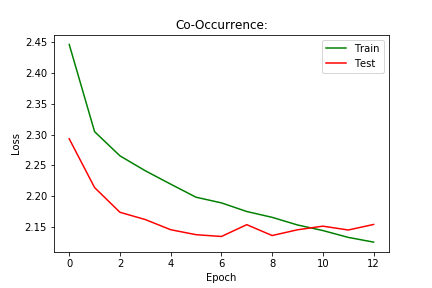

Starting
Epoch 1: 2.217409 seconds / epoch
Epoch 2: 2.255368 seconds / epoch
Epoch 3: 2.267443 seconds / epoch
Epoch 4: 2.258261 seconds / epoch
Epoch 5: 2.253073 seconds / epoch
Epoch 6: 2.260343 seconds / epoch
Epoch 7: 2.257402 seconds / epoch
Epoch 8: 2.266212 seconds / epoch
Epoch 9: 2.264468 seconds / epoch
Epoch 10: 2.265229 seconds / epoch
Epoch 11: 2.264512 seconds / epoch
Epoch 12: 2.275266 seconds / epoch


In [65]:
num_batches = 150
n_epochs = 13

co_model = predictor("Co-Occurrence:", co_occur, train_in, train_out, dev_in, dev_out, n_epochs, num_batches)

<IPython.core.display.Javascript object>


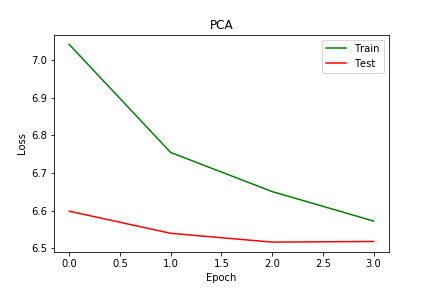

Starting
Epoch 1: 2.285876 seconds / epoch
Epoch 2: 2.395395 seconds / epoch
Epoch 3: 2.367239 seconds / epoch


In [66]:
num_batches = 150
n_epochs = 4

pca_model = predictor("PCA", embed_pca, train_in, train_out, dev_in, dev_out, n_epochs, num_batches)

<IPython.core.display.Javascript object>


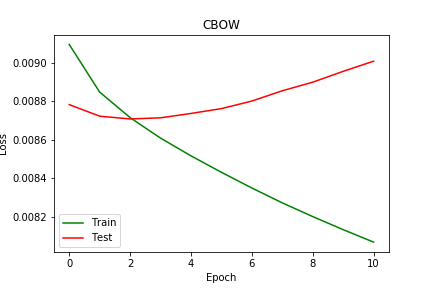

Starting
Epoch 1: 2.248827 seconds / epoch
Epoch 2: 2.297781 seconds / epoch
Epoch 3: 2.298488 seconds / epoch
Epoch 4: 2.295510 seconds / epoch
Epoch 5: 2.289502 seconds / epoch
Epoch 6: 2.288931 seconds / epoch
Epoch 7: 2.288110 seconds / epoch
Epoch 8: 2.290422 seconds / epoch
Epoch 9: 2.294038 seconds / epoch
Epoch 10: 2.289508 seconds / epoch


In [60]:
num_batches = 150
n_epochs = 3

cbow_model = predictor("CBOW", embed_cbow, train_in, train_out, dev_in, dev_out, n_epochs, num_batches)

<IPython.core.display.Javascript object>


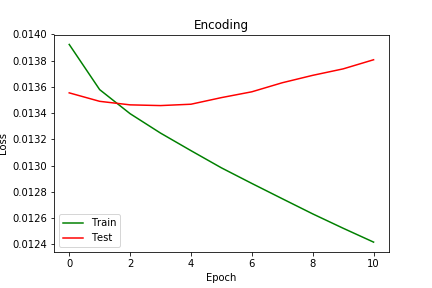

Starting
Epoch 1: 2.257495 seconds / epoch
Epoch 2: 2.266856 seconds / epoch
Epoch 3: 2.262460 seconds / epoch
Epoch 4: 2.267274 seconds / epoch
Epoch 5: 2.281204 seconds / epoch
Epoch 6: 2.282617 seconds / epoch
Epoch 7: 2.289201 seconds / epoch
Epoch 8: 2.297595 seconds / epoch
Epoch 9: 2.291882 seconds / epoch
Epoch 10: 2.292128 seconds / epoch


In [64]:
num_batches = 150
n_epochs = 4

encoding_model = predictor("Encoding", encode_cbow, train_in, train_out, dev_in, dev_out, n_epochs, num_batches)

In [67]:
def eval_model(model, embeddings, data, target):
    data = to_embeddings(data, embeddings)
    out = model(torch.FloatTensor(data)).data.detach().numpy()
    distances = np.diagonal(cosine_similarity(out, to_embeddings(target, embeddings)))
    total = np.sum(distances)
    return total / len(target)

In [68]:
print("Co-Occurrence:", eval_model(co_model.cpu(), co_occur, test_in, test_out))
print("PCA:", eval_model(pca_model.cpu(), embed_pca, test_in, test_out))
print("CBOW:", eval_model(cbow_model.cpu(), embed_cbow, test_in, test_out))
print("Encoding:", eval_model(encoding_model.cpu(), encode_cbow, test_in, test_out))

Co-Occurrence: 0.7522803694679353
PCA: 0.4080256788498862
CBOW: 0.23840842119532096
Encoding: 0.22776142195214844


In [74]:
def accuracy(model, embeddings, data, target):
    data = to_embeddings(data, embeddings)
    out = model(torch.FloatTensor(data)).data.detach().numpy()
    correct = 0
    total = len(target)
    for vec, t in zip(out, target):
        x = cosine_distances(np.expand_dims(vec, 0), embeddings.values.T).argmin()
        correct += int(x == t)
    
    return correct / len(target)
print("Co-Occurrence:", accuracy(co_model, co_occur, test_in, test_targets))
print("PCA:", accuracy(pca_model, embed_pca, test_in, test_targets))
print("CBOW:", accuracy(cbow_model, embed_cbow, test_in, test_targets))
print("Encoding:", accuracy(encoding_model, encode_cbow, test_in, test_targets))

Co-Occurrence: 0.09492010493679942
PCA: 0.11698068208919628
CBOW: 0.1236584784164083
Encoding: 0.11888862389697115
